# Music Tagging Transformer
This file implements and trains a transformer structure from scratch. We try to generalize a text-classification transformer for hte use of audio classification.
The basic implementation of the text-classification transformer is derived from [tensorflow tutorial](https://www.tensorflow.org/text/tutorials/transformer)

In [1]:
import logging
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow as tf

import tensorflow_text

/Users/mstuffer/.pyenv/versions/3.9.15/envs/ai-industry/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-01-24 17:18:13.879546: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Load and reshape dataset

The raw preprocessed audio data is loaded, splitted into the train, test and validation set and normalized.  
To make it compatible with the tensorflow structure, we convert them into three separate datasets

In [2]:
from lib_util import utils
from sklearn.model_selection import train_test_split

config = utils.get_config('transformer_exp')

preprocessed_data = utils.load_sliced_numpy_array('preprocessed_data')
labels = np.load('data/labels.npy')

labels_to_id = utils.get_class_mapping()

features_train, features_test_val, lab_train, lab_test_val = train_test_split(preprocessed_data, labels, train_size=config['train_set_size'], random_state=config['random_state'])
features_val, features_test, lab_val, lab_test             = train_test_split(features_test_val, lab_test_val, test_size=(config['val_set_size']/(1-config['train_set_size'])), shuffle=False)

# Check the shapes of the splitted sets
assert features_train.shape[0] == lab_train.shape[0] and features_test.shape[0] == lab_test.shape[0] and features_val.shape[0] == lab_val.shape[0]
assert features_train.shape[1] == features_test.shape[1] == features_val.shape[1] and lab_train.shape[1] == lab_test.shape[1] == lab_val.shape[1]

def normalization(features_train, features_test, features_val):
    """Normalize the data files by dividing every data point by the maximum of the train data set
    """
    maximum = np.amax(features_train)
    features_train = features_train/maximum
    features_test = features_test/maximum
    features_val = features_val/maximum
    return (features_train.astype(np.float32), features_test.astype(np.float32), features_val.astype(np.float32))

features_train, features_test, features_val = normalization(features_train, features_test, features_val)

features_train = features_train.reshape(features_train.shape[0], 48000, -1)
features_val   = features_val.reshape(features_val.shape[0], 48000, -1)
features_test   = features_test.reshape(features_test.shape[0], 48000, -1)

train_dataset = tf.data.Dataset.from_tensor_slices((features_train, lab_train))
val_dataset = tf.data.Dataset.from_tensor_slices((features_val, lab_val))
test_dataset = tf.data.Dataset.from_tensor_slices((features_test, lab_test))

Load slice from file preprocessed_data_001.npy
Load slice from file preprocessed_data_002.npy
Load slice from file preprocessed_data_003.npy
Load slice from file preprocessed_data_004.npy
Load slice from file preprocessed_data_005.npy
Load slice from file preprocessed_data_006.npy
Load slice from file preprocessed_data_007.npy
Load slice from file preprocessed_data_008.npy
Load slice from file preprocessed_data_009.npy
Loaded 9 files as slices, resulting shape: (4068, 48000)
training shape: (2440, 48000, 1)
Class distribution: [358 564 605 393 520]


2023-01-24 17:18:23.170484: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Having the splits, we convert the datasets of audio samples into batches.
We use `prefetch` according to [Better performance with the `tf.data`](https://www.tensorflow.org/guide/data_performance.ipynb).

In [3]:
BUFFER_SIZE = 20000
BATCH_SIZE = config['batch_size']

def make_batches(ds):
  return (
      ds
      .batch(BATCH_SIZE)
      .prefetch(buffer_size=tf.data.AUTOTUNE))

In [5]:
# Create training and validation set batches.
train_batches = make_batches(train_dataset)
val_batches = make_batches(val_dataset)
test_batches = make_batches(test_dataset)

The resulting `tf.data.Dataset` objects are setup for training with Keras.
Keras `Model.fit` training expects `(inputs, labels)` pairs.
The `inputs` are pairs of tokenized Portuguese and English sequences, `(pt, en)`.
The `labels` are the same English sequences shifted by 1.
This shift is so that at each location input `en` sequence, the `label` in the next token.


This is the same as the [text generation tutorial](text_generation.ipynb),
except here you have additional input "context" (the Portuguese sequence) that the model is "conditioned" on.

This setup is called "teacher forcing" because regardless of the model's output at each timestep, it gets the true value as input for the next timestep.
This is a simple and efficient way to train a text generation model.
It's efficient because you don't need to run the model sequentially, the outputs at the different sequence locations can be computed in parallel.

You might have expected the `input, output`, pairs to simply be the `Protugese, English` sequences.
Given the Portuguese sequence, the model would try to generate the English sequence.

It's possible to train a model that way. You'd need to write out the inference loop and pass the model's output back to the input.
It's slower (time steps can't run in parallel), and a harder task to learn (the model can't get the end of a sentence right until it gets the beginning right),
but it can give a more stable model because the model has to learn to correct its own errors during training.

# Define the components
Now, we implement the basic components of the transformer.  
We start with creating a `FeatureExtractor`, that computes a dense representation of our signal that can be fed later to our transformer (similar to text encoding). We choose dimensions that feature size is similar to the melspectograms. Creating larger representations slowed down trainings process significantly and exceeded our available memory. 

In [6]:
class FeatureExtractor:
    def __init__(self) -> None:
        self.conv_layers = [
            tf.keras.layers.Conv1D(8, 6, 1, padding='same', activation='gelu', data_format='channels_last'),
            tf.keras.layers.Conv1D(32, 4, 1, padding='same', activation='gelu', data_format='channels_last'),
            tf.keras.layers.Conv1D(64, 4, 4, padding='same', activation='gelu', data_format='channels_last'),
            tf.keras.layers.Conv1D(128, 3, 3, padding='same', activation='sigmoid', data_format='channels_last')
        ]

        self.max_pooling = tf.keras.layers.MaxPool1D(2)

        self.normalization = tf.keras.layers.LayerNormalization()

    def __call__(self, x):
        for convolution in self.conv_layers:
            x = convolution(x)
            x = self.max_pooling(x)

        return self.normalization(x)


# test dense representation size with an example from the trainings batch
feature_extractor = FeatureExtractor()
for e in train_batches.as_numpy_iterator():
  x = e
  break

x = feature_extractor(x[0])

print(x.shape)

(64, 250, 128)


Now, we use the basic components of the transofrmer, as implemented in [tensorflow tutorial](https://www.tensorflow.org/text/tutorials/transformer).  
For the encoding, we add our own `FeatureExtractor` and an `InputLayer`.

In [7]:
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)
  
  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1) 

  return tf.cast(pos_encoding, dtype=tf.float32)


class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, d_model):
    super().__init__()
    self.d_model = d_model
    self.pos_encoding = positional_encoding(length=config['pos_encoding_length'], depth=d_model)

  def call(self, x):
    length = tf.shape(x)[1]
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x


class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()


class CrossAttention(BaseAttention):
  def call(self, x, context):
    attn_output, attn_scores = self.mha(
        query=x,
        key=context,
        value=context,
        return_attention_scores=True)
   
    # Cache the attention scores for plotting later.
    self.last_attn_scores = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x


class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

class CausalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x,
        use_causal_mask = True)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x) 
    return x

class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x


class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads,
               dff, dropout_rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    self.pos_embedding = PositionalEmbedding(d_model=d_model)
    self.enc_layers = [
        EncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    # `x` is token-IDs shape: (batch, seq_len)
    x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.
    
    x = self.dropout(x)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x)

    return x  # Shape `(batch_size, seq_len, d_model)`.


class Transformer(tf.keras.Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff, n_labels,
               dropout_rate=0.1):
    super().__init__()

    self.input_layer = tf.keras.layers.InputLayer((48000, 1))

    self.feature_extractor = FeatureExtractor()

    self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           dropout_rate=dropout_rate)

    self.dropout_layer = tf.keras.layers.Dropout(dropout_rate)
    self.pooling_layer = tf.keras.layers.GlobalAvgPool1D()
    self.dense_layer = tf.keras.layers.Dense(4 * n_labels, 'selu')
    self.final_layer = tf.keras.layers.Dense(n_labels, activation='sigmoid')

  def call(self, inputs):
    # To use a Keras model with `.fit` you must pass all your inputs in the
    # first argument.

    x = self.input_layer(inputs)

    x = self.feature_extractor(x)

    x = self.encoder(x)  # (batch_size, x_len, d_model)

    x = self.dropout_layer(x)

    x = self.pooling_layer(x)

    x = self.dense_layer(x)

    # Final linear layer output.
    out = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

    return out

In [8]:
config = utils.get_config('transformer_exp')
model_config = config['model_structure']
num_layers = model_config['n_layers']
d_model = model_config['d_model']
dff = model_config['dff']
num_heads = model_config['n_heads']
dropout_rate = model_config['dropout_rate']

### Try it out

Instantiate the `Transformer` model:

In [9]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    dropout_rate=dropout_rate,
    n_labels=lab_train.shape[1])


## Training

A custom `learning rate` schedule with the `Adam` optimizer, as proposed in the original paper is provided. We increased that learning rate, since otherwise progress was too slow.

In [10]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2) * 5

learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

In [11]:
transformer.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=optimizer,
    metrics=[tf.keras.metrics.CategoricalAccuracy()])

es = tf.keras.callbacks.EarlyStopping(
    monitor = config['early_stopping']['monitor'],
    patience = config['early_stopping']['patience'],
    start_from_epoch=config['early_stopping']['start_from'],
    restore_best_weights=config['early_stopping']['restore_best_weights'])

cp = tf.keras.callbacks.ModelCheckpoint(
    filepath='models/my_transformer/',
    save_weights_only=True,
    monitor='val_loss',
    model='min',
    save_best_only=True)

hist = transformer.fit(train_batches,
                epochs=config['epochs'],
                callbacks=[es, cp],
                validation_data=val_batches)

Epoch 1/20
39/39 [==============================] - 1096s 27s/step - loss: 1.6067 - categorical_accuracy: 0.2754 - val_loss: 1.4667 - val_categorical_accuracy: 0.3796
Epoch 2/20
39/39 [==============================] - 1331s 34s/step - loss: 1.4924 - categorical_accuracy: 0.3561 - val_loss: 1.4876 - val_categorical_accuracy: 0.3821
Epoch 3/20
39/39 [==============================] - 1419s 36s/step - loss: 1.4120 - categorical_accuracy: 0.3930 - val_loss: 1.3442 - val_categorical_accuracy: 0.4349
Epoch 4/20
39/39 [==============================] - 1285s 33s/step - loss: 1.3809 - categorical_accuracy: 0.4004 - val_loss: 1.5241 - val_categorical_accuracy: 0.3587
Epoch 5/20
39/39 [==============================] - 1266s 32s/step - loss: 1.3665 - categorical_accuracy: 0.4270 - val_loss: 1.3153 - val_categorical_accuracy: 0.4423
Epoch 6/20
39/39 [==============================] - 1171s 30s/step - loss: 1.3450 - categorical_accuracy: 0.4266 - val_loss: 1.3149 - val_categorical_accuracy: 0.433

In [18]:
import json
transformer.save_weights('models/my_transformer/my_transformer')

with open('models/my_transformer/my_transformer_history.json', 'w') as f:
    f.write(json.dumps(hist.history, indent=4))


Plot the results from the training history

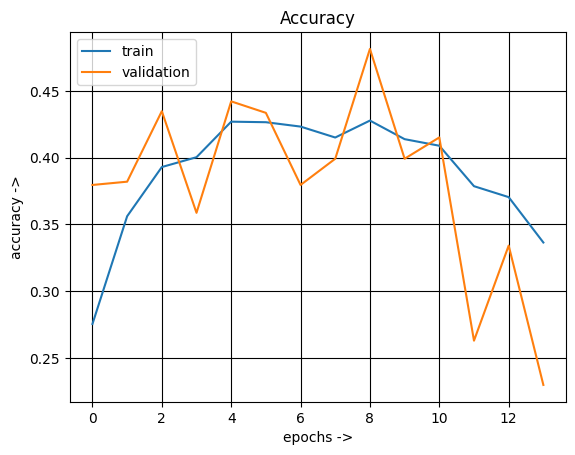

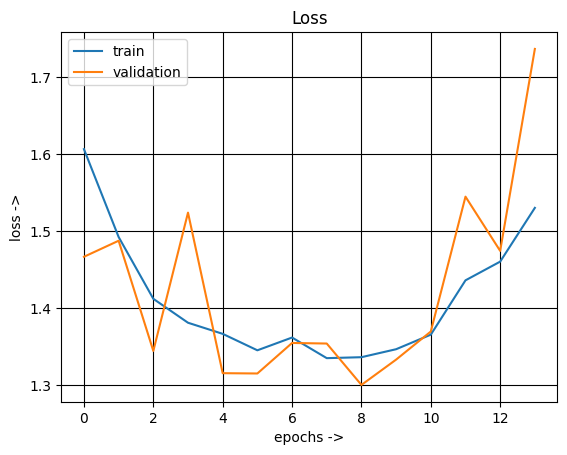

In [13]:
from lib_util import plot
epochs = config['epochs']
with open('models/my_transformer/my_transformer_history.json', 'r') as f:
     history_dict = json.load(f)

history_dict = hist.history
#Plots for the accuracies and losses of the train and validation data per epoch
name = config['transformer_name']
plot.plot_hist(history_dict, ('categorical_accuracy', 'val_categorical_accuracy'), legends=('train', 'validation'), title='Accuracy', y_label='accuracy ->', x_label='epochs ->', save_to=f'Plots/{name}_{epochs}_acuracy')
plot.plot_hist(history_dict, ('loss', 'val_loss'), legends=('train', 'validation'), title='Loss', y_label='loss ->', x_label='epochs ->', save_to=f'Plots/{name}_{epochs}_loss')

Reload the model from stored weights

In [21]:
from sklearn.metrics import confusion_matrix
from pandas import DataFrame
from lib_util import plot

# load the transformer structure
transformer_l = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    dropout_rate=dropout_rate,
    n_labels=lab_train.shape[1])

# load stored weights
transformer_l.build((None, 48000, 1))
transformer_l.load_weights('models/my_transformer/')

# compile model for prediction
learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

transformer_l.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=optimizer,
    metrics=[tf.keras.metrics.CategoricalAccuracy()])

Predict train and test sets from trained model

In [22]:
y_pred_train = transformer_l.predict(features_train)
y_pred_test = transformer_l.predict(features_test)

y_pred_classes_train = np.argmax(y_pred_train, axis=1)
y_pred_classes_test = np.argmax(y_pred_test, axis=1)

26/26 [==============================] - 132s 5s/step


In [30]:
from sklearn.metrics import accuracy_score, f1_score

y_true_train = np.argmax(lab_train, axis=1)
y_true_test = np.argmax(lab_test, axis=1)

print(f"Accuracy for train set: {accuracy_score(y_pred=y_pred_classes_train, y_true=y_true_train)}")
print(f"F1 score for train set: {f1_score(y_pred=y_pred_classes_train, y_true=y_true_train, average='weighted')}")

print(f"Accuracy for test set: {accuracy_score(y_pred=y_pred_classes_test, y_true=y_true_test)}")
print(f"F1 score for test set: {f1_score(y_pred=y_pred_classes_test, y_true=y_true_test, average='weighted')}")

Accuracy for train set: 0.30450819672131146
F1 score for train set: 0.2598824985727473
Accuracy for test set: 0.3022113022113022
F1 score for test set: 0.2578251005270399


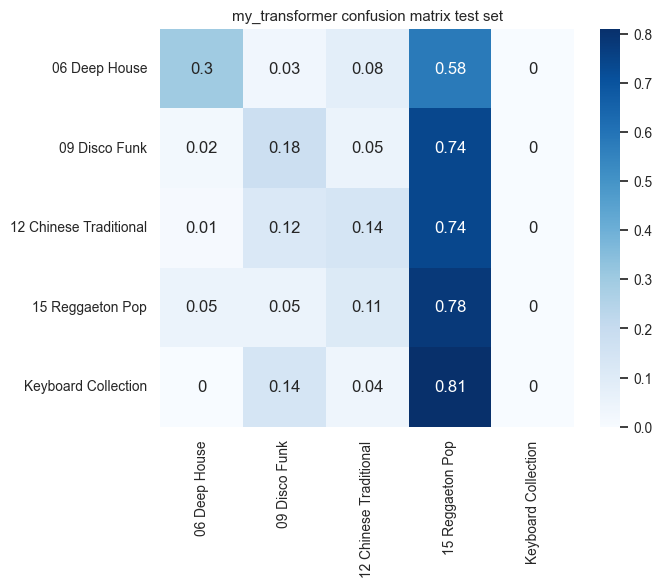

In [31]:
class_names = utils.get_class_names()

#Confusion matrix of the predicted labels versus the true labels
conf_mat = confusion_matrix(np.argmax(lab_test, axis=1), y_pred_classes_test, normalize= 'true')
conf_mat = np.round(conf_mat, 2)

conf_mat_df = DataFrame(conf_mat, columns=class_names, index=class_names)

plot.plot_conf_mat(conf_mat_df, save_to=f"Plots/{config['transformer_name']}_{epochs}_test_conf_mat.png", name=config['transformer_name'], set_type='test')